In [1]:
# Enhanced EDA for cryptocurrency futures data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
from scipy import stats
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load data - make sure to use the correct path
df = pd.read_csv('../binance_data_pipeline/data/markets/BTCUSDT_1d.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df[df["Timestamp"] >= "2023-06-25"]
df = df.set_index('Timestamp')

# Calculate the basis and APRs as you did before
binance_rate = 0.0001 * 3 * 365 * 100
df.rename(columns={"prompt_days_till_expiry": "prompt_dte", "next_days_till_expiry": "next_dte"}, inplace=True)
df["prompt_basis"] = df["prompt_close"] - df["spot_close"]
df["prompt_apr"] = (df["prompt_basis"] / df["spot_close"]) * (365 / df["prompt_dte"]) * 100 - binance_rate
df["prompt_apy"] = (np.exp(df["prompt_apr"] / 100) - 1) * 100

# Only use rows where next futures data is available
df_with_next = df.dropna(subset=['next_close']).copy()
df_with_next.loc[:, "next_basis"] = df_with_next["next_close"] - df_with_next["spot_close"]
df_with_next.loc[:, "next_apr"] = (df_with_next["next_basis"] / df_with_next["spot_close"]) * (365 / df_with_next["next_dte"]) * 100 - binance_rate
df_with_next.loc[:, "next_apy"] = (np.exp(df_with_next["next_apr"] / 100) - 1) * 100

# Calculate forward rate
df_with_next.loc[:, "forward_rate"] = ((df_with_next["next_close"] / df_with_next["prompt_close"]) - 1) * (365 / (df_with_next["next_dte"] - df_with_next["prompt_dte"])) * 100

# multiply funding rate by 100 to match APR units
df["funding_annualized"] *= 100
df["funding_annualized"] -= binance_rate

# Calculate returns for each instrument
df['spot_returns'] = df['spot_close'].pct_change() * 100
df['perp_returns'] = df['perp_close'].pct_change() * 100
df['prompt_returns'] = df['prompt_close'].pct_change() * 100

# Calculate volatility (20-day rolling standard deviation of returns)
df['spot_volatility'] = df['spot_returns'].rolling(window=20).std()
df['perp_volatility'] = df['perp_returns'].rolling(window=20).std()
df['prompt_volatility'] = df['prompt_returns'].rolling(window=20).std()

# Calculate the spread between funding rate and prompt APR
df['funding_prompt_spread'] = df['funding_annualized'] - df['prompt_apr']

# Calculate z-score of the spread (for mean reversion analysis)
df['funding_prompt_spread_zscore'] = (df['funding_prompt_spread'] - 
                                      df['funding_prompt_spread'].rolling(window=30).mean()) / \
                                      df['funding_prompt_spread'].rolling(window=30).std()

# Calculate the term structure slope
df_with_next.loc[:, "term_structure_slope"] = df_with_next["next_apr"] - df_with_next["prompt_apr"]

# Reset index for plotting
df.reset_index(inplace=True)
df_with_next.reset_index(inplace=True)

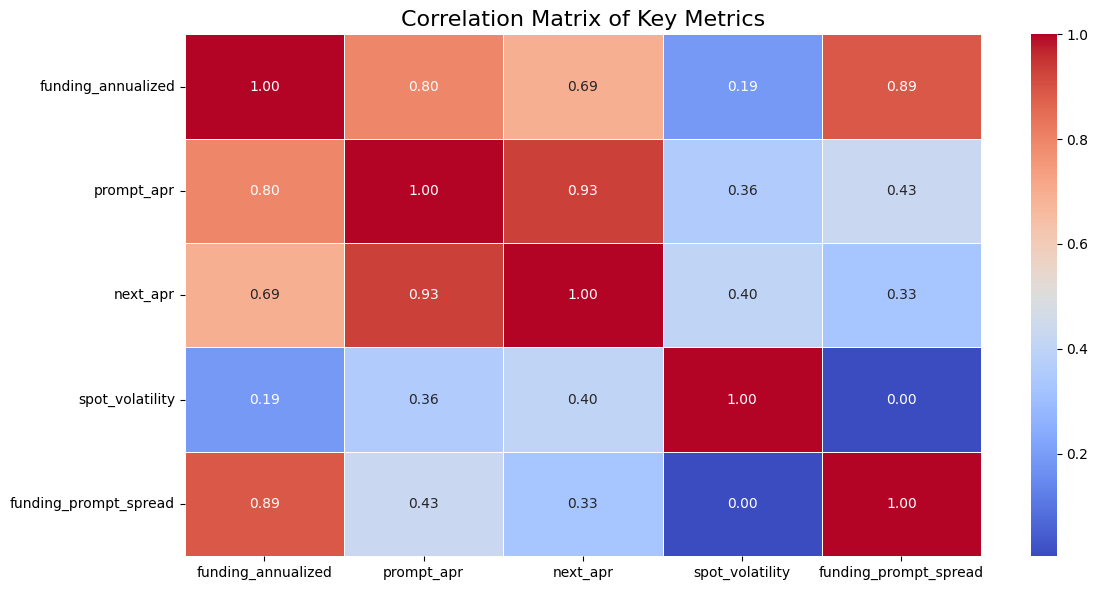

In [2]:
# Enhanced visualizations

df_with_next = df_with_next.merge(df[['Timestamp', 'spot_volatility', 'funding_prompt_spread']], on='Timestamp', how='left')
# 1. Correlation heatmap
plt.figure(figsize=(12, 6))
correlation_cols = ['funding_annualized', 'prompt_apr', 'next_apr', 
                    'spot_volatility', 'funding_prompt_spread']
correlation_matrix = df_with_next[correlation_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Key Metrics', fontsize=16)
plt.tight_layout()
plt.show()

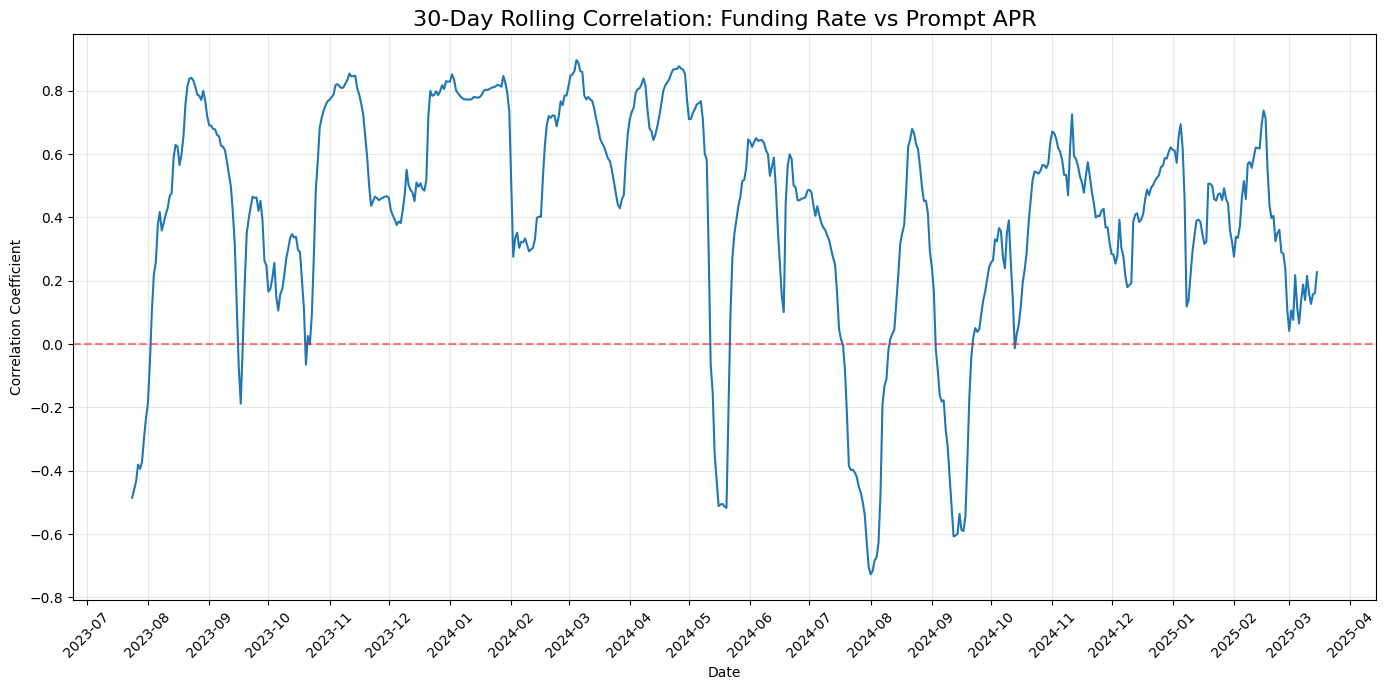

In [3]:
# 2. Rolling correlation between funding rate and prompt APR
plt.figure(figsize=(14, 7))
rolling_corr = df['funding_annualized'].rolling(window=30).corr(df['prompt_apr'])
plt.plot(df['Timestamp'], rolling_corr)
plt.title('30-Day Rolling Correlation: Funding Rate vs Prompt APR', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

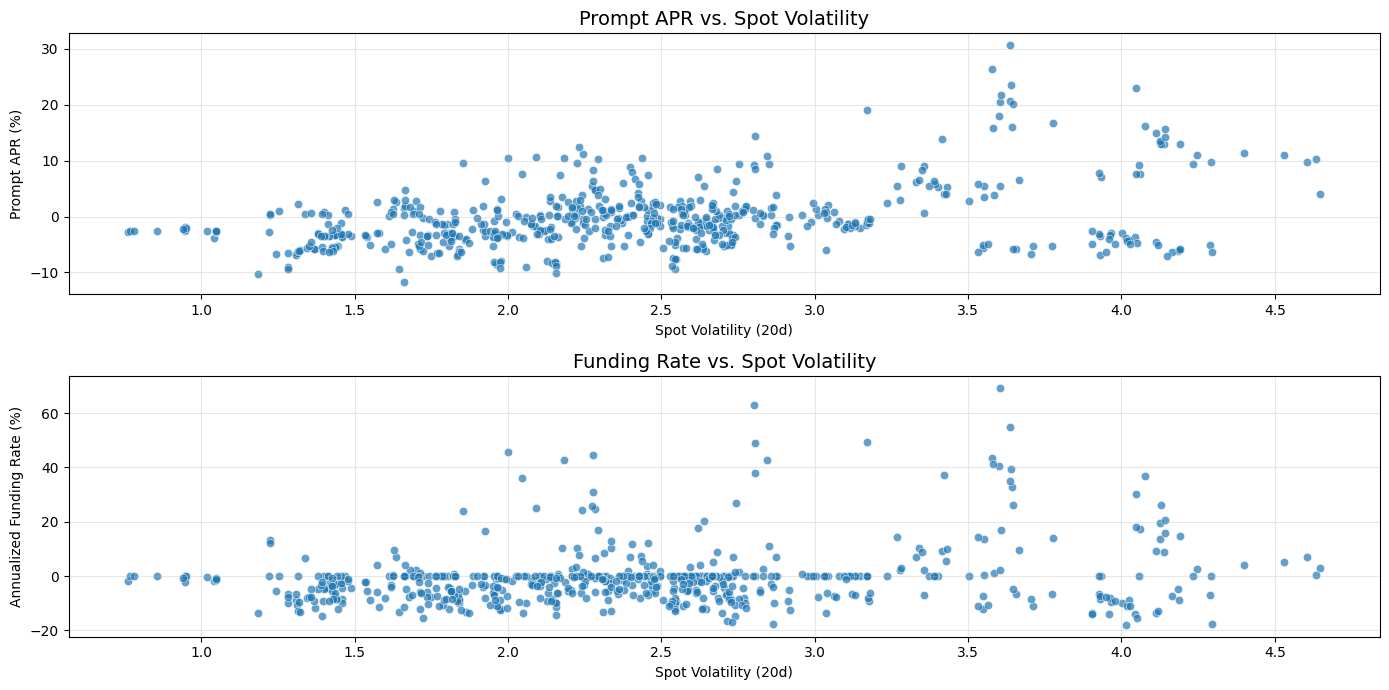

In [4]:
# 3. Relationship with volatility
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
sns.scatterplot(x=df['spot_volatility'], y=df['prompt_apr'], alpha=0.7)
plt.title('Prompt APR vs. Spot Volatility', fontsize=14)
plt.xlabel('Spot Volatility (20d)')
plt.ylabel('Prompt APR (%)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
sns.scatterplot(x=df['spot_volatility'], y=df['funding_annualized'], alpha=0.7)
plt.title('Funding Rate vs. Spot Volatility', fontsize=14)
plt.xlabel('Spot Volatility (20d)')
plt.ylabel('Annualized Funding Rate (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


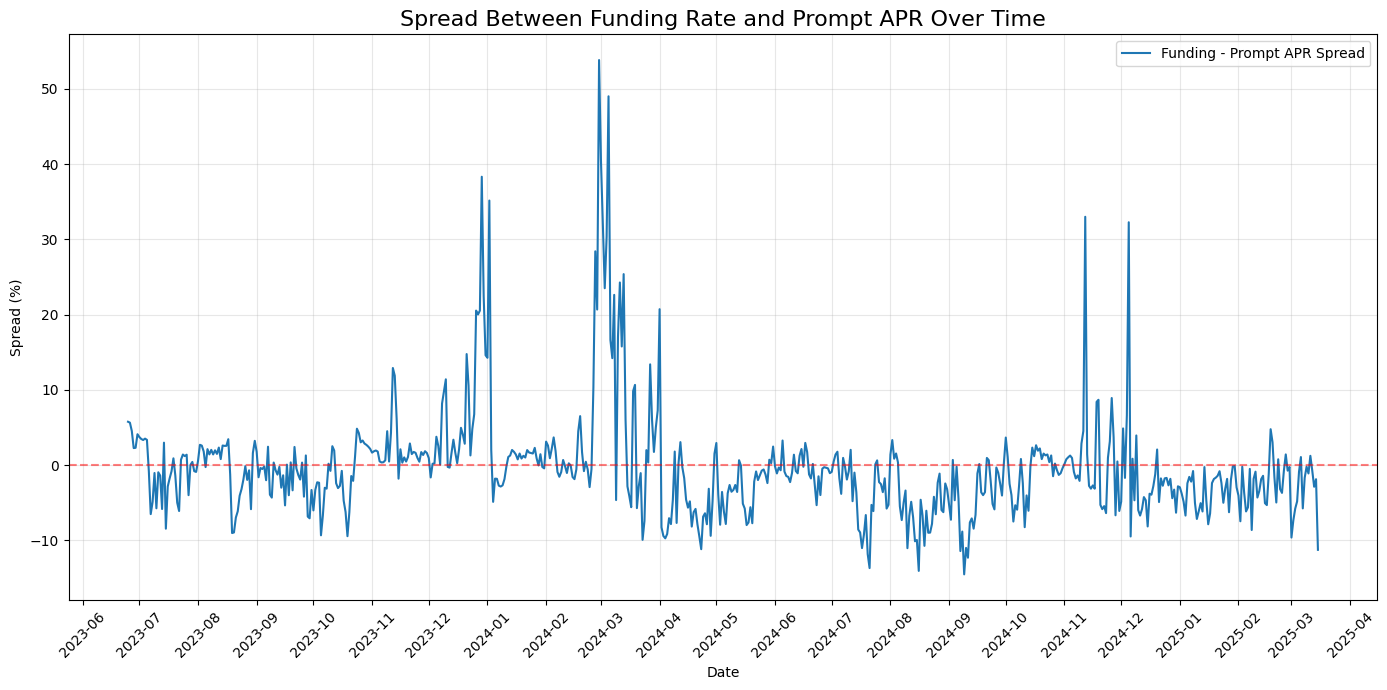

In [5]:
# 4. Time series of spreads
plt.figure(figsize=(14, 7))
plt.plot(df['Timestamp'], df['funding_prompt_spread'], label='Funding - Prompt APR Spread')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.title('Spread Between Funding Rate and Prompt APR Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Spread (%)')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

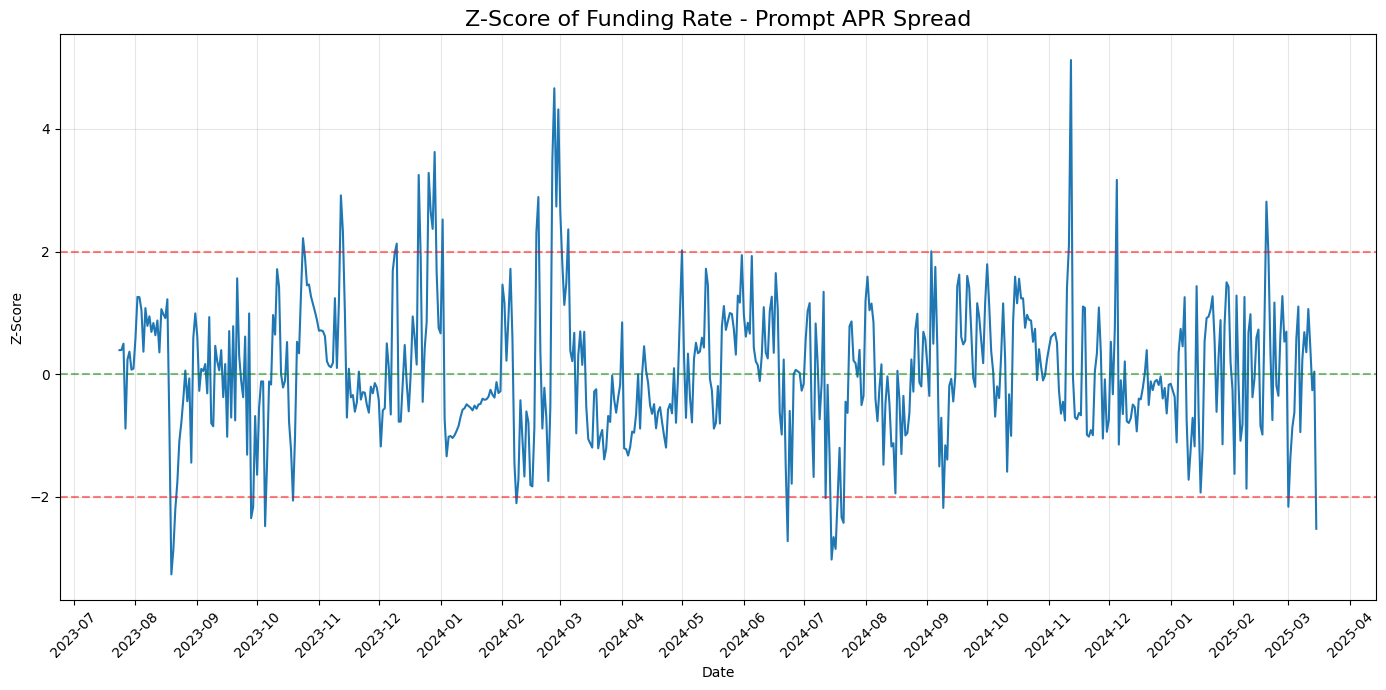

In [6]:
# 5. Z-score of the spread (for mean reversion analysis)
plt.figure(figsize=(14, 7))
plt.plot(df['Timestamp'], df['funding_prompt_spread_zscore'])
plt.axhline(y=2, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=-2, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=0, color='g', linestyle
            ='--', alpha=0.5)
plt.title('Z-Score of Funding Rate - Prompt APR Spread', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

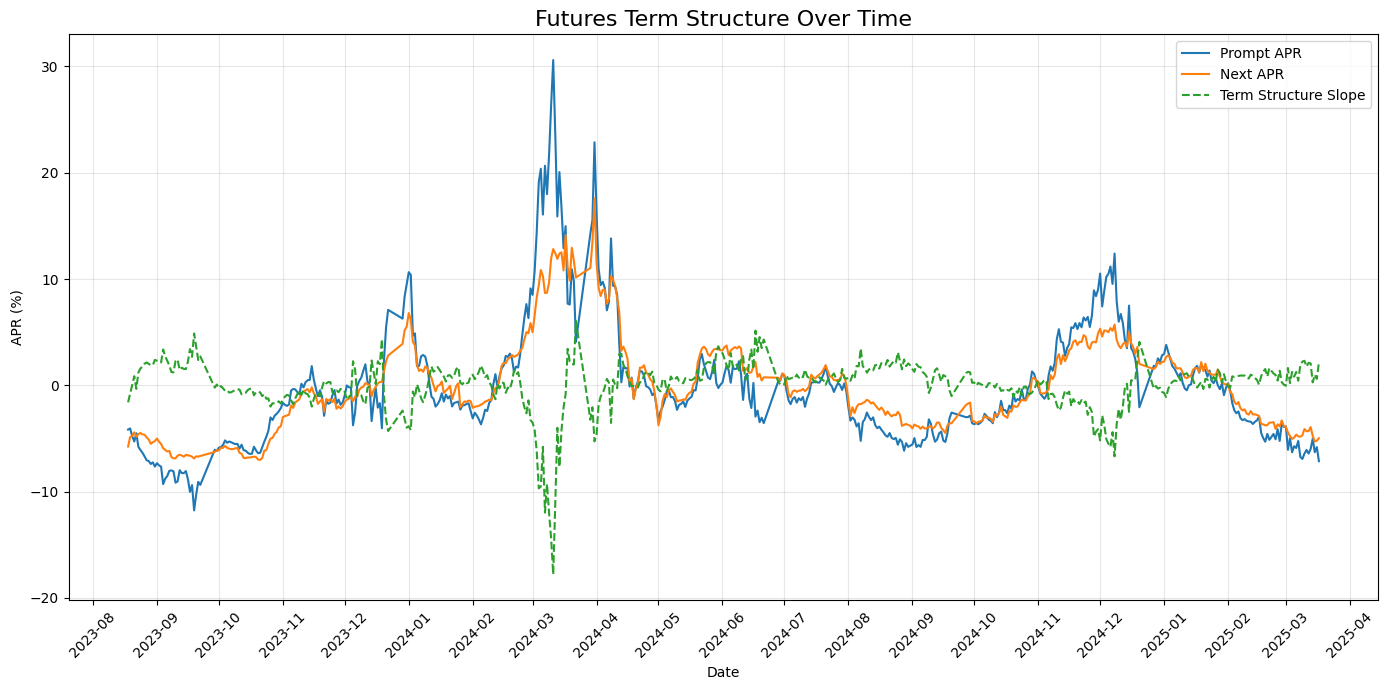

In [7]:
# 6. Term structure analysis (only on data with next futures)
plt.figure(figsize=(14, 7))
plt.plot(df_with_next['Timestamp'], df_with_next['prompt_apr'], label='Prompt APR')
plt.plot(df_with_next['Timestamp'], df_with_next['next_apr'], label='Next APR')
plt.plot(df_with_next['Timestamp'], df_with_next['term_structure_slope'], label='Term Structure Slope', linestyle='--')
plt.title('Futures Term Structure Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('APR (%)')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# 1. Augmented Dickey-Fuller Test for Stationarity
def run_adf_test(series, name):
    result = adfuller(series.dropna())
    print(f'ADF Test on {name}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values: {result[4]}')
    if result[1] < 0.05:
        print("Result: The series is stationary (reject unit root)")
    else:
        print("Result: The series is non-stationary (fail to reject unit root)")
    print("-" * 50)

print("Testing for Stationarity:")
run_adf_test(df['prompt_apr'], 'Prompt APR')
run_adf_test(df['funding_annualized'], 'Funding Rate')
run_adf_test(df['funding_prompt_spread'], 'Funding - Prompt Spread')

Testing for Stationarity:
ADF Test on Prompt APR:
ADF Statistic: -2.3626
p-value: 0.1526
Critical Values: {'1%': np.float64(-3.440975679277454), '5%': np.float64(-2.8662281164567927), '10%': np.float64(-2.5692666752547626)}
Result: The series is non-stationary (fail to reject unit root)
--------------------------------------------------
ADF Test on Funding Rate:
ADF Statistic: -4.4885
p-value: 0.0002
Critical Values: {'1%': np.float64(-3.440822526288827), '5%': np.float64(-2.8661606613087542), '10%': np.float64(-2.5692307337540603)}
Result: The series is stationary (reject unit root)
--------------------------------------------------
ADF Test on Funding - Prompt Spread:
ADF Statistic: -5.4563
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.440924132966757), '5%': np.float64(-2.866205413627313), '10%': np.float64(-2.5692545786625383)}
Result: The series is stationary (reject unit root)
--------------------------------------------------


In [9]:
# 2. Granger Causality Test
max_lag = 7  # Test up to 7 days lag
print("\nGranger Causality Tests:")
print("Does Funding Rate Granger-cause Prompt APR?")
granger_result = grangercausalitytests(df[['funding_annualized', 'prompt_apr']].dropna(), maxlag=max_lag)
for lag in range(1, max_lag + 1):
    f_stat = granger_result[lag][0]['ssr_ftest']
    print(f"Lag {lag}: F-statistic: {f_stat[0]:.4f}, p-value: {f_stat[1]:.4f}")
    
print("\nDoes Prompt APR Granger-cause Funding Rate?")
granger_result = grangercausalitytests(df[['prompt_apr', 'funding_annualized']].dropna(), maxlag=max_lag)
for lag in range(1, max_lag + 1):
    f_stat = granger_result[lag][0]['ssr_ftest']
    print(f"Lag {lag}: F-statistic: {f_stat[0]:.4f}, p-value: {f_stat[1]:.4f}")



Granger Causality Tests:
Does Funding Rate Granger-cause Prompt APR?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=61.6387 , p=0.0000  , df_denom=626, df_num=1
ssr based chi2 test:   chi2=61.9341 , p=0.0000  , df=1
likelihood ratio test: chi2=59.0714 , p=0.0000  , df=1
parameter F test:         F=61.6387 , p=0.0000  , df_denom=626, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=45.9723 , p=0.0000  , df_denom=623, df_num=2
ssr based chi2 test:   chi2=92.6825 , p=0.0000  , df=2
likelihood ratio test: chi2=86.4495 , p=0.0000  , df=2
parameter F test:         F=45.9723 , p=0.0000  , df_denom=623, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=30.1231 , p=0.0000  , df_denom=620, df_num=3
ssr based chi2 test:   chi2=91.3896 , p=0.0000  , df=3
likelihood ratio test: chi2=85.3131 , p=0.0000  , df=3
parameter F test:         F=30.1231 , p=0.0000  , df_denom=620, df_num=3

Granger Causality
numbe

In [10]:
# 3. Half-life of mean reversion for the spread
def calculate_half_life(spread):
    spread = spread.dropna()
    lag_spread = spread.shift(1)
    delta_spread = spread - lag_spread
    lag_spread = lag_spread.dropna()
    delta_spread = delta_spread.dropna()
    
    # Regression
    model = sm.OLS(delta_spread, sm.add_constant(lag_spread))
    result = model.fit()
    
    # Calculate half-life
    theta = -result.params.iloc[1]
    half_life = np.log(2) / theta if theta > 0 else np.inf
    
    return half_life, result.summary()

half_life, regression_summary = calculate_half_life(df['funding_prompt_spread'])
print(f"\nHalf-life of mean reversion for Funding-Prompt Spread: {half_life:.2f} days")
print("\nRegression Summary:")
print(regression_summary)


Half-life of mean reversion for Funding-Prompt Spread: 2.23 days

Regression Summary:
                              OLS Regression Results                             
Dep. Variable:     funding_prompt_spread   R-squared:                       0.155
Model:                               OLS   Adj. R-squared:                  0.153
Method:                    Least Squares   F-statistic:                     114.6
Date:                   Tue, 18 Mar 2025   Prob (F-statistic):           1.12e-24
Time:                           12:14:51   Log-Likelihood:                -1936.1
No. Observations:                    629   AIC:                             3876.
Df Residuals:                        627   BIC:                             3885.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---

In [11]:
# 4. Market regime clustering using K-means
print("\nIdentifying Market Regimes with K-means Clustering:")
# Select features for clustering
features = df[['spot_volatility', 'prompt_apr', 'funding_annualized']].dropna()
features_scaled = StandardScaler().fit_transform(features)

# Determine optimal number of clusters using silhouette score
from sklearn.metrics import silhouette_score
silhouette_scores = []
k_range = range(2, 6)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features_scaled)
    silhouette_scores.append(silhouette_score(features_scaled, cluster_labels))
    
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")


Identifying Market Regimes with K-means Clustering:
Optimal number of clusters: 2



Market Regime Characteristics:

Regime 0:
Number of days: 531
Average Spot Volatility: 2.30
Average Prompt APR: -1.92%
Average Funding Rate: -3.74%
Average Funding-Prompt Spread: -1.82%

Regime 1:
Number of days: 79
Average Spot Volatility: 3.30
Average Prompt APR: 10.96%
Average Funding Rate: 19.71%
Average Funding-Prompt Spread: 8.75%


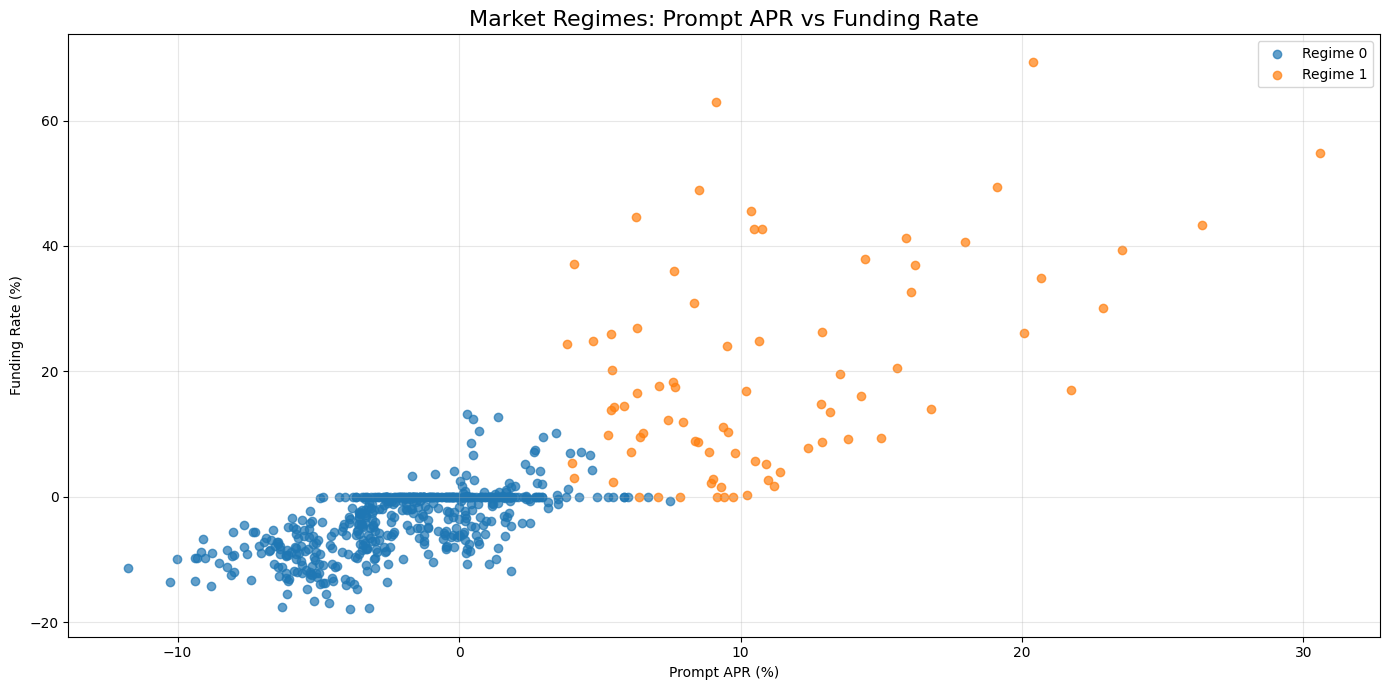

In [12]:
# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster = df.copy().dropna(subset=['spot_volatility', 'prompt_apr', 'funding_annualized'])
df_cluster['regime'] = kmeans.fit_predict(
    StandardScaler().fit_transform(df_cluster[['spot_volatility', 'prompt_apr', 'funding_annualized']])
)

# Summarize the clusters
print("\nMarket Regime Characteristics:")
for i in range(optimal_k):
    regime_data = df_cluster[df_cluster['regime'] == i]
    print(f"\nRegime {i}:")
    print(f"Number of days: {len(regime_data)}")
    print(f"Average Spot Volatility: {regime_data['spot_volatility'].mean():.2f}")
    print(f"Average Prompt APR: {regime_data['prompt_apr'].mean():.2f}%")
    print(f"Average Funding Rate: {regime_data['funding_annualized'].mean():.2f}%")
    print(f"Average Funding-Prompt Spread: {regime_data['funding_prompt_spread'].mean():.2f}%")

# Plot the regimes
plt.figure(figsize=(14, 7))
for i in range(optimal_k):
    regime_data = df_cluster[df_cluster['regime'] == i]
    plt.scatter(regime_data['prompt_apr'], regime_data['funding_annualized'], 
                label=f'Regime {i}', alpha=0.7)
plt.title('Market Regimes: Prompt APR vs Funding Rate', fontsize=16)
plt.xlabel('Prompt APR (%)')
plt.ylabel('Funding Rate (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#TLDR
#Just trying to think about mean-reversion, 
#clustering, volatility and a high-level of
#the interrelatedness of the market. 

#Looking at this and thinking about Part 2, it feels like implementing
#simple stat arb around rolling z-score of the funding vs futures APR
#should work if the trade can overcome the bid-ask, slippage, transaction fees.

#Does also feel like one could wear some delta given the mean reverting nature of 
#this market but that strikes me as outside the business case of Boros.